In [14]:
from datetime import datetime
from code.data import Data
from code.experiments import *

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
data = Data("lastfm-dataset-1K\userid-timestamp-artid-artname-traid-traname.tsv")

Skipping line 2120260: expected 6 fields, saw 8

Skipping line 2446318: expected 6 fields, saw 8

Skipping line 11141081: expected 6 fields, saw 8

Skipping line 11152099: expected 6 fields, saw 12
Skipping line 11152402: expected 6 fields, saw 8

Skipping line 11882087: expected 6 fields, saw 8

Skipping line 12902539: expected 6 fields, saw 8
Skipping line 12935044: expected 6 fields, saw 8

Skipping line 17589539: expected 6 fields, saw 8



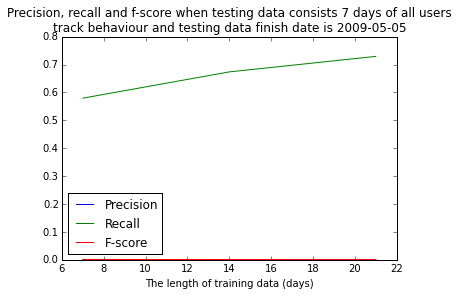

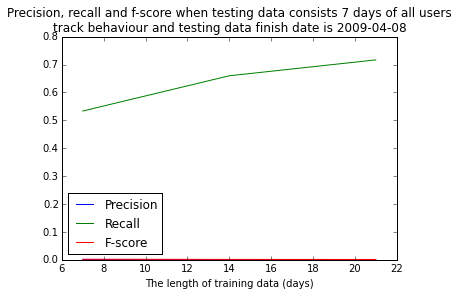

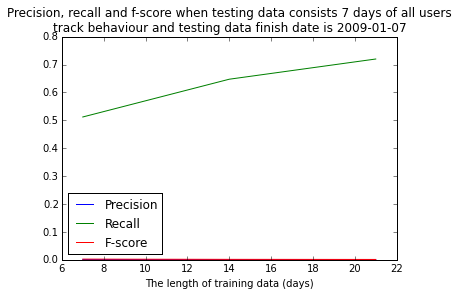

In [114]:
training_lengths = [21,14,7]
testing_lengths = [7]
testing_finish_dates = [datetime(2009, 5, 5), datetime(2009, 4, 8), datetime(2009, 1, 7)]

experiment = Experiment(training_lengths, testing_lengths, 
                        testing_finish_dates, type='all_previous_tracks')
experiment.run(data, exp_id=1)

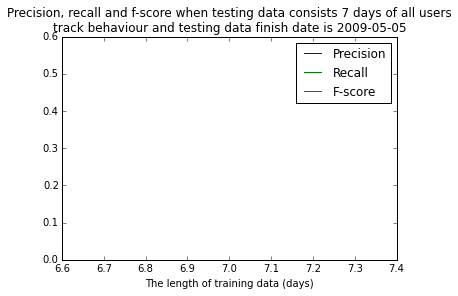

In [8]:
training_lengths = [7]
testing_lengths = [7]
testing_finish_dates = [datetime(2009, 5, 5)]

experiment = DataExperiment(training_lengths, testing_lengths, 
                        testing_finish_dates, type='all_previous_tracks')
experiment.run(data, exp_id=1)

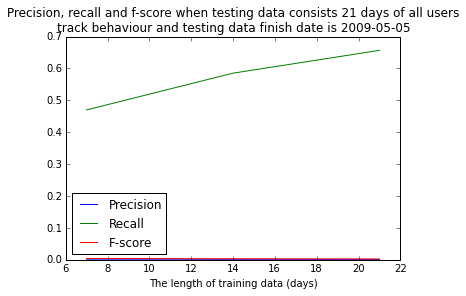

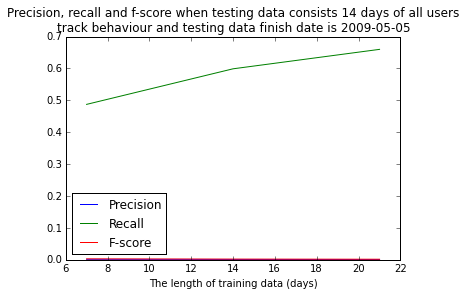

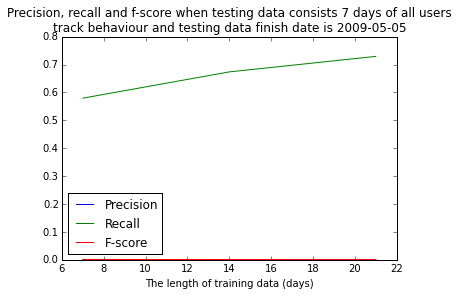

In [115]:
training_lengths = [21,14,7]
testing_lengths = [21,14,7]
testing_finish_dates = [datetime(2009, 5, 5)]

experiment = Experiment(training_lengths, testing_lengths, 
                        testing_finish_dates, type='all_previous_tracks')
experiment.run(data, exp_id=1)

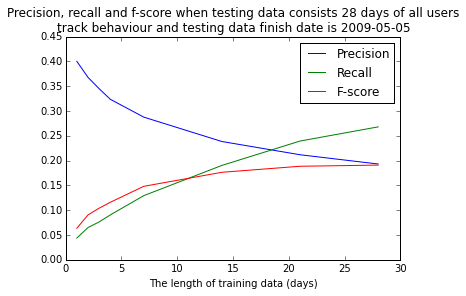

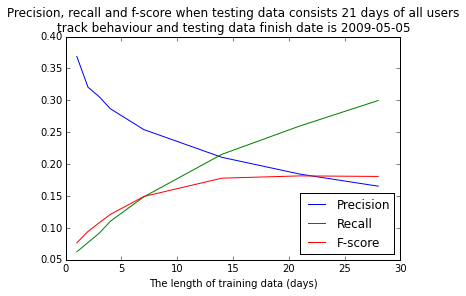

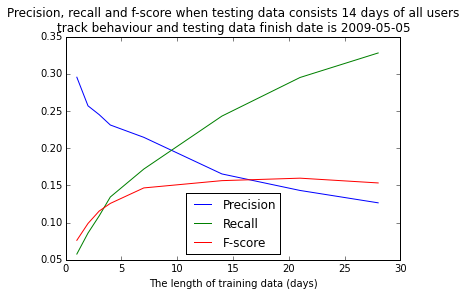

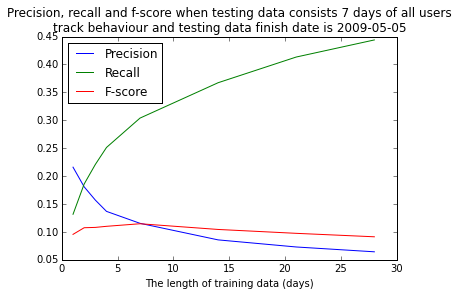

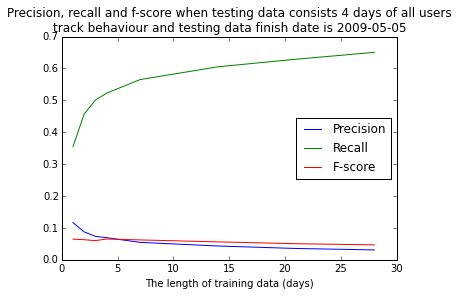

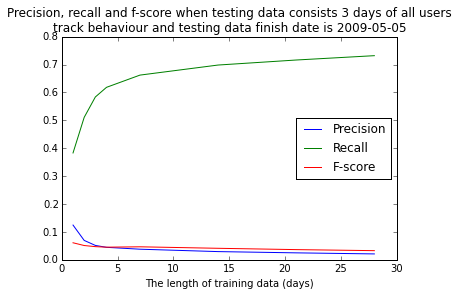

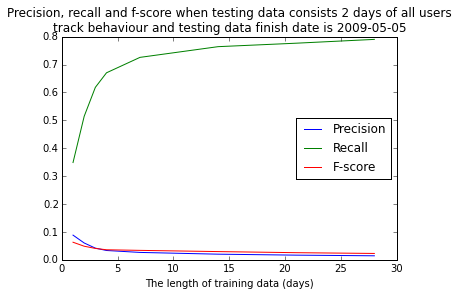

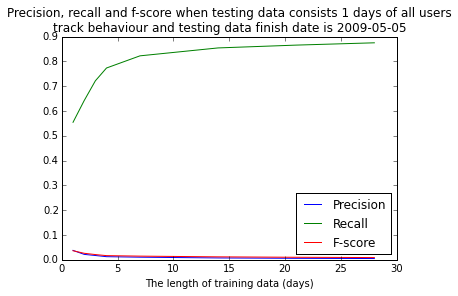

In [111]:
training_lengths = [28,21,14,7,4,3,2,1]
testing_lengths = [28,21,14,7,4,3,2,1]
testing_finish_dates = [datetime(2009, 5, 5)]#, datetime(2009, 4, 28), datetime(2009, 1, 1)]

experiment = Experiment(training_lengths, testing_lengths, 
                        testing_finish_dates, type='user_previous_tracks')
experiment.run(data, exp_id=1)

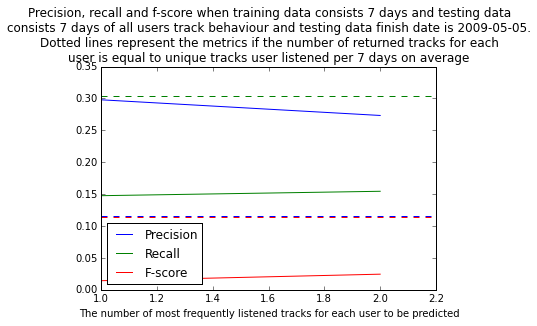

In [15]:
n = [i for i in xrange(0, 600, 20)]
n = [0,1,2]
training_length = 7
testing_length = 7
finish_testing = datetime(2009, 5, 5)
experiment = NMostOftenExperiment(training_length, testing_length, 
                                  finish_testing, data, exp_id=2, n_values=n)
experiment.run()

In [23]:
model = Model('n_most_often', data, id_0, 0)
model.run()

==== n_most_often ====
Model precision: 0.101351071923
Model recall: 0.305581152481
F1 score: 0.101958648557


(0.1013510719225647, 0.3055811524814172, 0.10195864855658361)

The modularity of the network is 0.997703


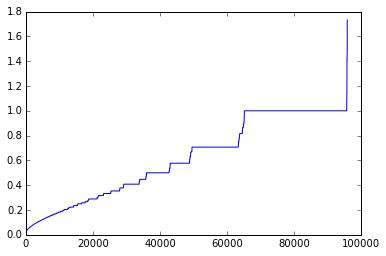

In [4]:
from code.clustering import TrackClustering
id_0 = data.create_experiment_data(7, 7, datetime(2009, 5, 5), 0, True)
training_data = data.get_training_data(id_0)
clustering = TrackClustering(training_data, 60, 0.5)
clustering.run(plot_similarities=True)

In [5]:
# Pick randomly from cluster
from code.models import Model
model = Model('from_clusters_randomly', data, id_0, cluster=clustering)
model.run()

==== from_clusters_randomly ====
Model precision: 0.0943763841195
Model recall: 0.274889013433
F1 score: 0.0934597440735


(0.09437638411951232, 0.2748890134330772, 0.09345974407352757)

In [118]:
# Pick everything from the same clusters
from code.models import Model
model = Model('from_clusters_all', data, id_0, cluster=clustering)
model.run()

==== from_clusters_all ====
Model precision: 0.0413473209357
Model recall: 0.31757420223
F1 score: 0.0488867946537


(0.041347320935742796, 0.3175742022300341, 0.048886794653744986)

In [119]:
# Pick by user track frequency from cluster
from code.models import Model
model = Model('from_cluster_by_user_track_freq', data, id_0, cluster=clustering)
model.run()

==== from_cluster_by_user_track_freq ====
Model precision: 0.115391539179
Model recall: 0.303923845349
F1 score: 0.114608420871


(0.11539153917941852, 0.30392384534947803, 0.11460842087132823)

In [ ]:
(0.08777498574030573, 0.2105537411359492, 0.06964460656854184)
# Above not allows clusters <= 1 in size
# (0.08994986329032331, 0.22576150831764272, 0.07746522314737116)
# Allowing all clusters
#(0.09044191861126076, 0.32640826614648893, 0.09965851997669273) 

In [100]:
# concatenated frequent and neighbors 
from code.models import Model
model = Model('from_cluster_by_common_neighbors', data, id_0, cluster=clustering)
model.run()

==== from_cluster_by_common_neighbors ====
Model precision: 8.17167045287e-05
Model recall: 0.000185787273572
F1 score: 0.000113508022179


(8.171670452873977e-05, 0.00018578727357176033, 0.00011350802217946753)

In [5]:
# only neighbors
from code.models import Model
model = Model('from_cluster_by_common_neighbors', data, id_0, cluster=clustering)
model.run()

==== from_cluster_by_common_neighbors ====
Model precision: 0.143550832141
Model recall: 0.176919616125
F1 score: 0.0813952107949


(0.14355083214091702, 0.17691961612507923, 0.08139521079491958)

In [ ]:
# only neighbors
from code.models import Model
model = Model('by_common_neighbors', data, id_0, cluster=clustering)
model.run()

==== by_common_neighbors ====
Model precision: 0.160753563597
Model recall: 0.178441045417
F1 score: 0.0848058892443


(0.16075356359706575, 0.17844104541658393, 0.08480588924427827)

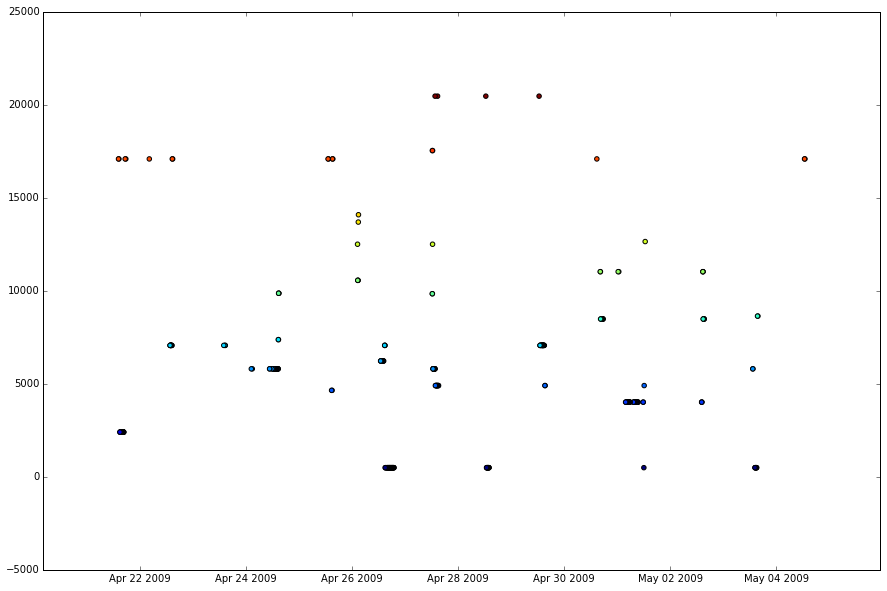

In [117]:
plt.figure(figsize=(15,10), dpi=1000)
axes = plt.gca()
#axes.set_xlim(['2009-05-04 13:06:09','2009-04-21 14:16:27'])
plt.scatter(times, cluster_ids, c=cluster_ids)